In [1]:
import math
import os
import shutil
import pandas aqs pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import tifffile
import torchvision.transforms.functional as TF
import torch
from pathlib import Path
from collections import Counter

from skimage.measure import regionprops_table, regionprops
from skimage.morphology import label, binary_erosion
from skimage.segmentation import expand_labels
from skimage.exposure import rescale_intensity
from einops import rearrange


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mip.utils import listfiles, extract_ome_tiff, R_CHANNEL_MAPPING, make_pseudo, display_region

#### in house

In [5]:
out_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/region_analysis_v3'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [6]:
name_map = {
    'HT110B1_S1H4': 'HT110B1-S1H4',
    'HT171B1-S1H9A1-4_left_05122023': 'HT171B1-S1H9A1-4_left_05122023',
    'HT171B1-S1H9A1-4_right_05122023': 'HT171B1-S1H9A1-4_right_05122023',
    'HT206B1_H1': 'HT206B1-H1',
    'HT206B1_H1_06252022': 'HT206B1_H1_06252022',
    'HT206B1_S1H2L4_20221028': 'HT206B1_S1H2L4',
    'HT243B1-S1H4A4_04192023': 'HT243B1-S1H4A4_04192023',
    'HT243B1-S1H4A4_left_05122023': 'HT243B1-S1H4A4_left_05122023',
    'HT243B1-S1H4A4_right_05122023': 'HT243B1-S1H4A4_right_05122023',
    'HT243B1_S1H4': 'HT243B1-S1H4',
    'HT271B1-S1H6A5_04192023': 'HT271B1-S1H6A5_04192023',
    'HT271B1-S1H6A5_left_05122023': 'HT271B1-S1H6A5_left_05122023',
    'HT271B1-S1H6A5_right_05122023': 'HT271B1-S1H6A5_right_05122023',
#     'HT271B1_S1H3A5_02172023': 'HT271B1_S1H3A5',
    'HT297B1_H1_08042022': 'HT297B1-H1-08042022',
    'HT305B1_S1H1': 'HT305B1-S1H1',
    'HT308B1-S1H5A4_04192023': 'HT308B1-S1H5A4_04192023',
    'HT308B1-S1H5A4_left_05122023': 'HT308B1-S1H5A4_left_05122023',
    'HT308B1-S1H5A4_right_05122023': 'HT308B1-S1H5A4_right_05122023',
    'HT323B1_H1A1': 'HT323B1-H1A1',
    'HT323B1_H1A4': 'HT323B1-H1A4',
    'HT323B1_H1_08042022': 'HT323B1-H1-08042022',
    'HT323B1_H3': 'HT323B1-H3',
    'HT339B1_H1A1': 'HT339B1-H1A1',
    'HT339B1_H2A1': 'HT339B1-H2A1',
    'HT339B1_H4A4': 'HT339B1-H4A4',
    'HT365B1_S1H1_02132023': 'HT365B1_S1H1',
    'HT397B1_H2A2': 'HT397B1-H2A2',
    'HT397B1_H3A1': 'HT397B1-H3A1',
    'HT397B1_S1H1A3U22_04122023': 'HT397B1_S1H1A3U22_04122023',
    'HT397B1_S1H1A3U31_04062023': 'HT397B1_S1H1A3U31_04062023',
    'HT397B1_U12_03172023': 'HT397B1_U12_03172023',
    'HT397B1_U2_03162023': 'HT397B1_U2_03162023',
    'HT480B1_S1H2_R001': 'HT480B1-S1H2-R001',
    'HT480B1_S1H2_R002': 'HT480B1-S1H2-R002',
    'HT565B1-H2_04262023': 'HT565B1-H2_04262023',
    'HT342C1_Th1K4A1_section1_03042022': 'HT342C1_Th1K4A1_section1_03042022',
    'HT342C1_Th1K4A1_section2_03042022': 'HT342C1_Th1K4A1_section2_03042022',
    'HT347C1_Th1K2A1_section1_03042022': 'HT347C1_Th1K2A1_section1_03042022',
    'HT347C1_Th1K2A1_section2_03042022': 'HT347C1_Th1K2A1_section2_03042022',
    'HT413C1-K2_04262023': 'HT413C1-K2_04262023',
    'HT488C1-Th1K1Fp1-U14_041823': 'HT488C1-Th1K1Fp1-U14_041823',
    'HT488C1-Th1K1Fp1-U2_041323': 'HT488C1-Th1K1Fp1-U2_041323',
    'HT553P1-H2_04262023': 'HT553P1-H2_04262023',
    'HT427P1_S1H1A3_20221020': 'HT427P1_S1H1A3',
}
r_name_map = {v:k for k, v in name_map.items()}

In [7]:
mask_fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask',
                         regex='tif$'))
mask_fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT110B1_S1H4.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT171B1-S1H9A1-4_left_05122023.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT171B1-S1H9A1-4_right_05122023.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT206B1_H1.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT206B1_H1_06252022.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT206B1_S1H2L4_20221028.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT243B1-S1H4A4_04192023.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan

In [8]:
adata_fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan',
                         regex='level_4/.*h5ad$'))
adata_fps = [fp for fp in adata_fps
             if '.ome.tiff' not in fp
             if 'cell_annotation' not in fp
             if 'metacluster' not in fp
             if 'spatial_features' not in fp]

In [9]:
samples = sorted(name_map.keys())
samples

['HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT206B1_H1',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_right_05122023',
 'HT297B1_H1_08042022',
 'HT305B1_S1H1',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_right_05122023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT339B1_H1A1',
 'HT339B1_H2A1',
 'HT339B1_H4A4',
 'HT342C1_Th1K4A1_section1_03042022',
 'HT342C1_Th1K4A1_section2_03042022',
 'HT347C1_Th1K2A1_section1_03042022',
 'HT347C1_Th1K2A1_section2_03042022',
 'HT365B1_S1H1_02132023',
 'HT397B1_H2A2',
 'HT397B1_H3A1',
 'HT397B1_S1H1A3U22_04122023',
 'HT397B1_S1H1A3U31_04062023',
 'HT397B1_U12_03172023',
 'HT397B1_U2_03162023',
 'HT413C1-K2_04262023',
 'HT427P1_S1H1A3_20221020',
 'H

In [10]:
ome_fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan',
                         regex='level_2/[^/]+.ome.tiff$'))
ome_fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/041523_BM_SN002_SN056_SN024/level_2/SN002_left_04152023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/041523_BM_SN002_SN056_SN024/level_2/SN002_right_04152023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/041523_BM_SN002_SN056_SN024/level_2/SN024_left_04152023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/041523_BM_SN002_SN056_SN024/level_2/SN024_right_04152023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/041523_BM_SN002_SN056_SN024/level_2/SN056_left_04152023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/041523_BM_SN002_SN056_SN024/level_2/SN056_right_04152023.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/bm/20230114_BoneMarrow_SN002_SN050/level_2/SN002_SN050.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/l

In [11]:
len(samples), len(mask_fps), len(ome_fps)

(44, 45, 108)

In [12]:
sample_to_mask = {}
for fp in mask_fps:
    s = fp.split('/')[-1].replace('.tif', '')
    sample_to_mask[s] = fp
    
sample_to_adata = {}
for fp in adata_fps:
    s = fp.split('/')[-1].replace('.h5ad', '')
    sample_to_adata[s] = fp
    
sample_to_ome = {}
for fp in ome_fps:
    s = fp.split('/')[-1].replace('.ome.tiff', '')
    if s in r_name_map:
        s = r_name_map[s]
        sample_to_ome[s] = fp
    else:
        print(s)

SN002_left_04152023
SN002_right_04152023
SN024_left_04152023
SN024_right_04152023
SN056_left_04152023
SN056_right_04152023
SN002_SN050
HT271B1_S1H3A5
HT171B1-S1H9A1-4_04192023
HT339B2-H1_04262023
HT171B1-S1H1A1
HT171B1-S1H1A4
HT271B1-S1H3A5
HT171B1_S1H8A1_20221122
HT171B1_S1H1A1
HT171B1_S1H1A4
HT271B1_S1H3A5
HT171B1_20221205
HT206B1_Ctrl
HT308B1
test
S15_1909_A3_Section3_03082023
S15_1909_C2_Section3_03092023
CRC112
SN001H1
HT434P1-H1
codex_processed_hu_pancreas_TrisEDTA_2020-10-08
K1301459_3
K2200446_3PB
K2200452_2PB
K2200444_2PB
pkd_14519_38d_02232023
pkd_14801_38d_02232023
pkd_738_21d_02232023
pkd_743_21d_02232023
K2200453_2_03012023
K2200487_2_03012023
K2200493_2_03012023
K2200581-3_04202023
K2200591-2_04202023
K2200609-2_04202023
pkd_21d_04212023
pkd_28d_04212023
pkd_38d_s1_04212023
pkd_38d_s2_04212023
E16.5_female_section1_04272023
E16.5_female_section2_04272023
E16.5_male_section1_04272023
E16.5_male_section2_04272023
P1_female_section1_04272023
P1_female_section2_04272023
P1_ma

In [13]:
a = set(sample_to_adata.keys())
b = set(sample_to_mask.keys())
c = set(sample_to_ome.keys())

len(a.intersection(b).intersection(c))

44

In [14]:
s = next(iter(sample_to_mask.keys()))
s

'HT110B1_S1H4'

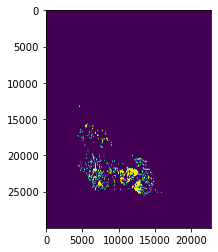

In [15]:
mask = tifffile.imread(sample_to_mask[s])
plt.imshow(mask)

In [16]:
labeled = label(mask)
props = regionprops(labeled)

In [17]:
a = sc.read_h5ad(sample_to_adata[s])
a

AnnData object with n_obs × n_vars = 77651 × 26
    obs: 'row', 'col', 'bbox-r1', 'bbox-c1', 'bbox-r2', 'bbox-c2', 'area', 'DAPI_intensity', 'CD8_intensity', 'CD138_intensity', 'CD4_intensity', 'cKit_intensity', 'Pan-Cytokeratin_intensity', 'GLUT1_intensity', 'Podoplanin_intensity', 'CK17_intensity', 'HLA-DR_intensity', 'GATA3_intensity', 'CD36_intensity', 'MGP_intensity', 'CK14_intensity', 'SMA_intensity', 'CD68_intensity', 'CD20_intensity', 'Vimentin_intensity', 'CD3e_intensity', 'CD163_intensity', 'Ki67_intensity', 'PR_intensity', 'ER_intensity', 'P16_intensity', 'CK19_intensity', 'P21 (D)_intensity', 'cell_type'
    uns: 'gating_strategy', 'thresholds'
    obsm: 'spatial'

In [18]:
channel_to_img = extract_ome_tiff(sample_to_ome[s])
channel_to_img = {R_CHANNEL_MAPPING.get(k, k):v for k, v in channel_to_img.items()}
channel_to_img.keys()

dict_keys(['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'GATA3', 'CD36', 'MGP', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD3e', 'CD163', 'Ki67', 'PR', 'ER', 'P16', 'CK19', 'P21'])

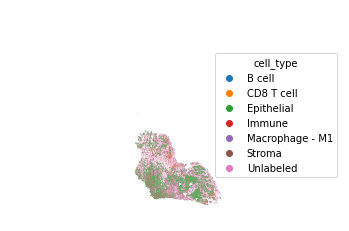

In [19]:
sns.scatterplot(data=a.obs, x='col', y='row', hue='cell_type', s=.1)
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()

In [20]:
def fast_expand_labels(labeled, dist, props=None):
    if props is None:
        props = regionprops(labeled)
    new = np.zeros_like(labeled)
    for prop in props:
        r1, c1, r2, c2 = prop.bbox
        r1, c1 = max(r1 - dist * 2, 0), max(c1 - dist * 2, 0)
        r2, c2 = r2 + dist * 2, c2 + dist * 2
        new[r1:r2, c1:c2][expand_labels(labeled[r1:r2, c1:c2], dist)==prop.label] = prop.label
    return new

def fast_shrink_labels(labeled, dist, props=None):
    if props is None:
        props = regionprops(labeled)
    new = np.zeros_like(labeled)
    for prop in props:
        r1, c1, r2, c2 = prop.bbox
        r1, c1 = max(r1 - dist * 2, 0), max(c1 - dist * 2, 0)
        r2, c2 = r2 + dist * 2, c2 + dist * 2
        
        tile = labeled[r1:r2, c1:c2]==prop.label
        for i in range(dist):
            tile = binary_erosion(tile)
        new[r1:r2, c1:c2][labeled[r1:r2, c1:c2]==prop.label] = 0
        new[r1:r2, c1:c2][tile] = prop.label
    return new

In [21]:
def compute_polsby_popper(area, perimeter):
    try:
        return 4 * math.pi * area / perimeter ** 2
    except ZeroDivisionError:
        return math.nan

def get_regionprops_df(labeled_img,
                       feats=('label', 'bbox', 'area', 'perimeter', 'centroid')):
    regions = regionprops_table(labeled_img, properties=feats)
    region_df = pd.DataFrame(regions)
    region_df = region_df.set_index('label')
    region_df.columns = ['r1', 'c1', 'r2', 'c2', 'area', 'perimeter', 'row', 'col']
    region_df['compactness'] = compute_polsby_popper(region_df['area'], region_df['perimeter'])
    return region_df

In [22]:
def get_morphology_masks(labeled_img, myoepi_dist=(20, 40), boundary_dist=150):
    props = regionprops(labeled_img)

    mask = labeled_img > 0
    
    ductal = fast_shrink_labels(labeled_img, myoepi_dist[0], props=props)
    ductal_mask = ductal > 0

    # myoepithelial
    outer_labeled = fast_expand_labels(labeled_img, myoepi_dist[1], props=props)
    myoepi_labeled = np.zeros_like(labeled_img)
    outer_mask = outer_labeled>0
    myoepi_mask = outer_mask ^ ductal_mask
    myoepi_labeled[myoepi_mask] = outer_labeled[myoepi_mask]

    # boundary
    outer_labeled = fast_expand_labels(labeled_img, boundary_dist, props=props)
    boundary_labeled = np.zeros_like(labeled_img)
    outer_mask = outer_labeled>0
    boundary_mask = outer_mask ^ mask
    boundary_labeled[boundary_mask] = outer_labeled[boundary_mask]

    labeled_dict = {
        'region': labeled_img.astype(np.int16),
        'ductal': ductal.astype(np.int16),
        'myoepi': myoepi_labeled.astype(np.int16),
        'boundary': boundary_labeled.astype(np.int16),
        'expanded': outer_labeled.astype(np.int16),
    }
    mask_dict = {
        'region': mask,
        'ductal': ductal_mask,
        'myoepi': myoepi_mask,
        'boundary': boundary_mask,
        'expanded': outer_mask
    }

    return labeled_dict, mask_dict

In [23]:
def calculate_annotation_fractions(adata, labeled, key):
    pool = sorted(set(adata.obs[key]))
    regions = []
    for row, col in zip(adata.obs['row'], adata.obs['col']):
        row, col = int(row), int(col)
        regions.append(labeled[row, col])
    regions = np.asarray(regions)
    
    data = []
    for region in range(1, labeled.max() + 1, 1):
        f = adata.obs[regions==region]
        counts = Counter(f[key])
        if f.shape[0]:
            data.append([counts.get(cat, 0) / f.shape[0] for cat in pool])
        else:
            data.append([np.nan] * len(pool))
    df = pd.DataFrame(data=data, columns=pool, index=list(range(1, labeled.max() + 1, 1)))
    return df
        

In [24]:
def calculate_marker_intensities(channel_to_img, labeled):
    data, labels = [], []
    channels = sorted(set(channel_to_img.keys()))
    stacked = np.concatenate([np.expand_dims(channel_to_img[c], -1) for c in channels], axis=-1)
    props = regionprops(labeled, intensity_image=stacked)
    for prop in props:
        labels.append(prop.label)
        data.append(prop.intensity_mean.tolist())
            
    
    df = pd.DataFrame(data=data, columns=channels, index=labels)
    return df


In [25]:
def calculate_marker_fractions(channel_to_img, adata, labeled):
    data, labels = [], []
    channels = [c.replace('_fraction', '') for c in adata.var.index.to_list()]
    channel_to_thresh = {c:thresh for c, thresh in zip(channels, adata.uns['thresholds'])
                if thresh > 0 and thresh not in [254., 255., 65534., 65535.]}
    channels = sorted(set(channel_to_thresh.keys()))
    stacked = np.concatenate([np.expand_dims(channel_to_img[c] >= channel_to_thresh[c], -1)
                              for c in channels], axis=-1)
    props = regionprops(labeled, intensity_image=stacked)
    for p in props:
        labels.append(p.label)
        data.append(p.image_intensity.sum(axis=(0, 1)) / (p.image_intensity.shape[0] * p.image_intensity.shape[1]))

    df = pd.DataFrame(data=data, columns=channels, index=labels)
    return df


In [26]:
samples

['HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT206B1_H1',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_right_05122023',
 'HT297B1_H1_08042022',
 'HT305B1_S1H1',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_right_05122023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT339B1_H1A1',
 'HT339B1_H2A1',
 'HT339B1_H4A4',
 'HT342C1_Th1K4A1_section1_03042022',
 'HT342C1_Th1K4A1_section2_03042022',
 'HT347C1_Th1K2A1_section1_03042022',
 'HT347C1_Th1K2A1_section2_03042022',
 'HT365B1_S1H1_02132023',
 'HT397B1_H2A2',
 'HT397B1_H3A1',
 'HT397B1_S1H1A3U22_04122023',
 'HT397B1_S1H1A3U31_04062023',
 'HT397B1_U12_03172023',
 'HT397B1_U2_03162023',
 'HT413C1-K2_04262023',
 'HT427P1_S1H1A3_20221020',
 'H

In [27]:
samples = [
    'HT342C1_Th1K4A1_section1_03042022',
    'HT342C1_Th1K4A1_section2_03042022',
    'HT347C1_Th1K2A1_section1_03042022',
    'HT347C1_Th1K2A1_section2_03042022',
    'HT365B1_S1H1_02132023',
    'HT397B1_H2A2',
    'HT397B1_H3A1',
    'HT397B1_S1H1A3U22_04122023',
    'HT397B1_S1H1A3U31_04062023',
    'HT397B1_U12_03172023',
    'HT397B1_U2_03162023',
    'HT413C1-K2_04262023',
    'HT427P1_S1H1A3_20221020',
    'HT480B1_S1H2_R001',
    'HT480B1_S1H2_R002',
    'HT488C1-Th1K1Fp1-U14_041823',
    'HT488C1-Th1K1Fp1-U2_041323',
    'HT553P1-H2_04262023',
    'HT565B1-H2_04262023'
]

In [28]:
cmap = {
    'Pan-Cytokeratin': (1., 0., 0.),
    'SMA': (0., 1., 0.),
    'DAPI': (0., 0., 1.),
    'Podoplanin': (1., 1., 1.),
}
scale = .1

In [29]:
for s in samples:
    print(s)
    a = sc.read_h5ad(sample_to_adata[s])
    mask = tifffile.imread(sample_to_mask[s])
    channel_to_img = extract_ome_tiff(sample_to_ome[s])
    channel_to_img = {R_CHANNEL_MAPPING.get(k, k):v for k, v in channel_to_img.items()}
    
    labeled = label(mask)
    props = regionprops(labeled)
    
    labeled_dict, mask_dict = get_morphology_masks(labeled)
    
    type_to_table = {}
    for k in labeled_dict.keys():
        df_meta = get_regionprops_df(labeled_dict[k])

        df_fracs = calculate_annotation_fractions(a, labeled_dict[k], 'cell_type')
        df_fracs.columns = [f'cell_type_fraction_{c}' for c in df_fracs.columns]

        df_marker_intensities = calculate_marker_intensities(channel_to_img, labeled_dict[k])
        df_marker_intensities.columns = [f'marker_intensity_{c}' for c in df_marker_intensities.columns]

        df_marker_fracs = calculate_marker_fractions(channel_to_img, a, labeled_dict[k])
        df_marker_fracs.columns = [f'marker_fraction_{c}' for c in df_marker_fracs.columns]

        combined = pd.merge(df_meta, df_fracs, left_index=True, right_index=True, how='left')
        combined = pd.merge(combined, df_marker_intensities, left_index=True, right_index=True, how='left')
        combined = pd.merge(combined, df_marker_fracs, left_index=True, right_index=True, how='left')
        
        type_to_table[k] = combined
    
    channel_to_img = {c:img for c, img in channel_to_img.items() if c in cmap}
    channels = sorted(set(channel_to_img.keys()))
    
    # psuedo
    pseudo = make_pseudo(channel_to_img, cmap=cmap, contrast_pct=95.)
    pseudo *= 255.
    pseudo = pseudo.astype(np.uint8)
    x = torch.tensor(rearrange(pseudo, 'h w c -> c h w'))
    x = TF.resize(x, size=(int(x.shape[-2] * scale), int(x.shape[-1] * scale)))
    pseudo_thumbnail = rearrange(x.numpy(), 'c h w -> h w c')
    
    # labeled
    thumbnails_labeled = {}
    for k, img in labeled_dict.items():
        labeled = torch.tensor(img)
        labeled = labeled.unsqueeze(0)
        labeled = TF.resize(labeled, size=(int(labeled.shape[-2] * scale), int(labeled.shape[-1] * scale)),
                           antialias=False, interpolation=TF.InterpolationMode.NEAREST)
        thumbnails_labeled[k] = labeled.squeeze().numpy()
        
    # masks
    thumbnails_mask = {}
    for k, img in mask_dict.items():
        mask = torch.tensor(img)
        mask = mask.unsqueeze(0)
        mask = TF.resize(mask, size=(int(labeled.shape[-2] * scale), int(labeled.shape[-1] * scale)),
                        antialias=False, interpolation=TF.InterpolationMode.NEAREST)
        thumbnails_mask[k] = mask.squeeze().numpy()
        
    to_save = {
        'images': {
            'fullres':{
                'labeled': labeled_dict,
                'mask': mask_dict,
                'pseudo': torch.tensor(pseudo)
            },
            'thumbnail': {
                'labeled': thumbnails_labeled,
                'mask': thumbnails_mask,
                'pseudo': pseudo_thumbnail
            }
        },
        'tables': type_to_table,
    }

    torch.save(to_save, os.path.join(out_dir, f'{s}_results.pt'))
    

HT342C1_Th1K4A1_section1_03042022
HT342C1_Th1K4A1_section2_03042022
HT347C1_Th1K2A1_section1_03042022
HT347C1_Th1K2A1_section2_03042022
HT365B1_S1H1_02132023
HT397B1_H2A2
HT397B1_H3A1
HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04062023
HT397B1_U12_03172023
HT397B1_U2_03162023
HT413C1-K2_04262023
HT427P1_S1H1A3_20221020
HT480B1_S1H2_R001
HT480B1_S1H2_R002
HT488C1-Th1K1Fp1-U14_041823
HT488C1-Th1K1Fp1-U2_041323
HT553P1-H2_04262023
HT565B1-H2_04262023


1

## Sandbox

In [327]:
sample_to_mask['HT271B1_S1H3A5_02172023']

'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v2/preprocessing/htan/region_mask/HT271B1_S1H3A5_02172023.tif'

In [328]:
sample_to_adata['HT271B1_S1H3A5_02172023']

'/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_4/HT271B1_S1H3A5_02172023.h5ad'

In [ ]:
combined = None
for s, result in sample_to_results.items():
    df = result['table'].copy()
    df.index = [f'{s}_{x}' for x in df.index]
    df.index.name = 'label'
    df['sample'] = s
    
    df = df.transpose()
    
    if combined is None:
        combined = df
    else:
        combined = pd.merge(combined, df, left_index=True, right_index=True, how='outer')
combined = combined.transpose()
combined.index.name = 'label'
combined

In [ ]:
region_to_bbox = {reg:(r1, c1, r2, c2) for reg, r1, c1, r2, c2 in zip(
                    combined.index.to_list(),
                    combined['r1'], combined['c1'],
                    combined['r2'], combined['c2'])}

In [ ]:
from einops import rearrange

In [ ]:
cmap = {
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD8a': (0., 1., 0.),
    'DAPI': (0., 0., 1.),
    'SMA': (1., 1., 1.),
    'CD45': (1., 1., 0.),
}

In [ ]:
scale = .1
sample_to_thumbnails = {}

for s, result in sample_to_results.items():
    print(s)
    channel_to_img = extract_ome_tiff(sample_to_ome[s])
    channel_to_img = {c:img for c, img in channel_to_img.items() if c in cmap}
    channels = sorted(set(channel_to_img.keys()))
    
    # psuedo
    pseudo = make_pseudo(channel_to_img, cmap=cmap, contrast_pct=95.)
    x = torch.tensor(rearrange(pseudo, 'h w c -> c h w'))
    x = TF.resize(x, size=(int(x.shape[-2] * scale), int(x.shape[-1] * scale)))
    pseudo_thumbnail = rearrange(x.numpy(), 'c h w -> h w c')
    
    # labeled
    thumbnails_labeled = {}
    for k, img in result['labeled_dict'].items():
        labeled = torch.tensor(img)
        labeled = labeled.unsqueeze(0)
        labeled = TF.resize(labeled, size=(int(labeled.shape[-2] * scale), int(labeled.shape[-1] * scale)),
                           antialias=False, interpolation=TF.InterpolationMode.NEAREST)
        thumbnails_labeled[k] = labeled.squeeze().numpy()
        
    # masks
    thumbnails_mask = {}
    for k, img in result['mask_dict'].items():
        mask = torch.tensor(img)
        mask = mask.unsqueeze(0)
        mask = TF.resize(mask, size=(int(labeled.shape[-2] * scale), int(labeled.shape[-1] * scale)),
                        antialias=False, interpolation=TF.InterpolationMode.NEAREST)
        thumbnails_mask[k] = mask.squeeze().numpy()
        
    to_save = {
        'pseudo': {
            'fullres': pseudo,
            'thumbnail': pseudo_thumbnail
        },
        'labeled': thumbnails_labeled,
        'mask': thumbnails_mask
    }

In [311]:
region_to_bbox_thumbnail = {k:(int(r1 * scale), int(c1 * scale), int(r2 * scale), int(c2 * scale))
                           for k, (r1, c1, r2, c2) in region_to_bbox.items()}

In [312]:
ncols = 6
nrows = (len(sample_to_thumbnails) // ncols) + 1

In [314]:
fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
stack = list(sample_to_thumbnails.items())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        
        if len(stack):
            s, thumbnails = stack.pop(0)
            labeled = thumbnails['pseudo']['fullres']
            ax.imshow(labeled)
            ax.set_title(s)
        ax.axis('off')

Error in callback <function flush_figures at 0x7ff93c3914d0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
stack = list(sample_to_thumbnails.items())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        
        if len(stack):
            s, thumbnails = stack.pop(0)
            labeled = thumbnails['pseudo']['thumbnail']
            ax.imshow(labeled)
            ax.set_title(s)
        ax.axis('off')

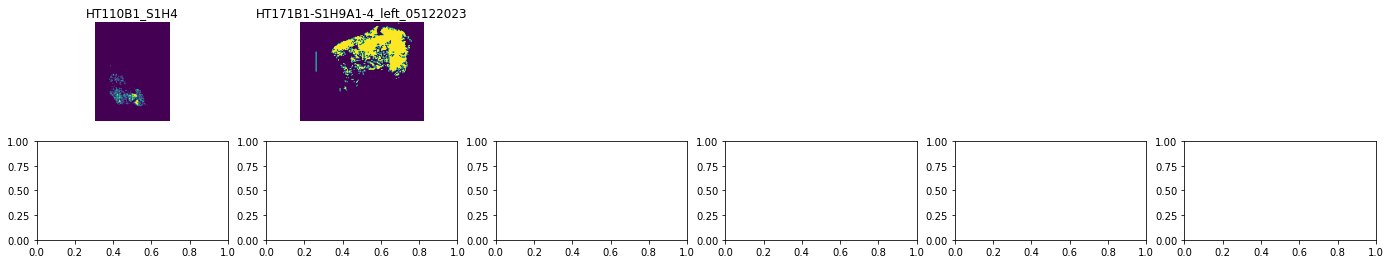

In [249]:
fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
stack = list(sample_to_thumbnails.items())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        
        if len(stack):
            s, thumbnails = stack.pop(0)
            labeled = thumbnails['mask']['region']
            ax.imshow(labeled)
            ax.set_title(s)
        ax.axis('off')

In [293]:
def display_legend(cmap, n=50):
    fig, axs = plt.subplots(nrows=1, ncols=len(cmap))
    for i, (name, c) in enumerate(cmap.items()):
        ax = axs[i]
        rect = np.zeros((n, n, 3), dtype=np.float32)
        print(c)
        rect[:, :] = c
        ax.imshow(rect)
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
        
def get_display_image(s, labeled, region_to_bbox, vmax=None,
                      color='region_grid_metrics_SMA_integrity', cmap='viridis', df=None):
    if df is None:
        df = combined

    f = df[df['sample']==s]
    f.index = [x.split('_')[-1] for x in f.index]
    rbbox = {reg.split('_')[-1]:tup for reg, tup in region_to_bbox.items() if s in reg}
    region_to_val = {reg:v
                     for reg, v in zip(f.index, f[color])}
    if region_to_val:
        rgba = utils.display_region(labeled, region_to_val, rbbox, cmap=cmap, vmax=vmax)
    else:
        rgba = np.ones((labeled.shape[0], labeled.shape[1], 4))
    return rgba
        
def show_regions(df, feat, cmap=None, vmax=None):
    fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    stack = list(sample_to_thumbnails.items())
    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i, j]
            if len(stack):
                s, thumbnails = stack.pop(0)
                labeled = thumbnails['labeled']['region']

                img = get_display_image(s, labeled, region_to_bbox_thumbnail, color=feat, df=df, cmap=cmap)
                ax.imshow(img)
                ax.set_title(s)
            ax.axis('off') 
    


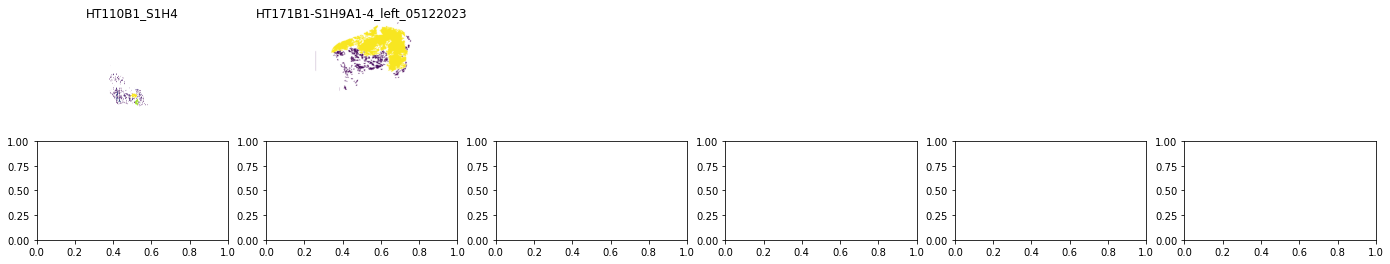

In [294]:
show_regions(combined, 'area')

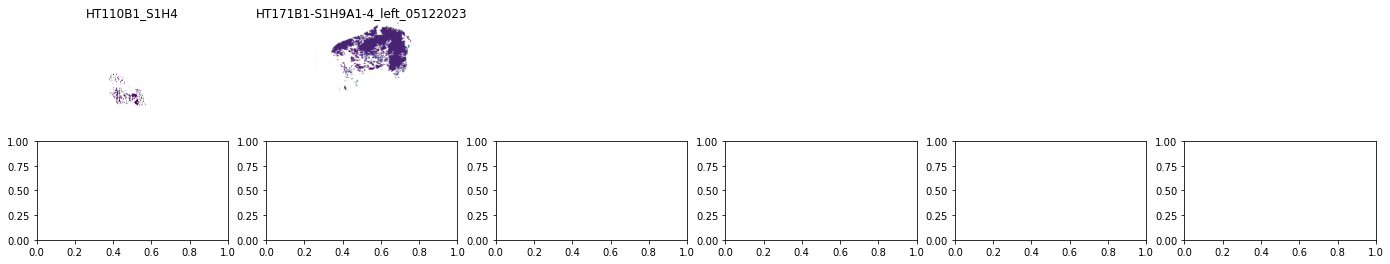

In [296]:
show_regions(combined, 'cell_type_fraction_CD8 T cell')

In [295]:
list(combined.columns)

['r1',
 'c1',
 'r2',
 'c2',
 'area',
 'perimeter',
 'row',
 'col',
 'compactness',
 'cell_type_fraction_B cell',
 'cell_type_fraction_CD8 T cell',
 'cell_type_fraction_Epithelial',
 'cell_type_fraction_Immune',
 'cell_type_fraction_Macrophage - M1',
 'cell_type_fraction_Stroma',
 'cell_type_fraction_Unlabeled',
 'marker_intensity_CD138',
 'marker_intensity_CD163',
 'marker_intensity_CD20',
 'marker_intensity_CD36',
 'marker_intensity_CD3e',
 'marker_intensity_CD4',
 'marker_intensity_CD68',
 'marker_intensity_CD8',
 'marker_intensity_CK14',
 'marker_intensity_CK17',
 'marker_intensity_CK19',
 'marker_intensity_DAPI',
 'marker_intensity_ER',
 'marker_intensity_GATA3',
 'marker_intensity_GLUT1',
 'marker_intensity_HLA-DR',
 'marker_intensity_Ki67',
 'marker_intensity_MGP',
 'marker_intensity_P16',
 'marker_intensity_P21',
 'marker_intensity_PR',
 'marker_intensity_Pan-Cytokeratin',
 'marker_intensity_Podoplanin',
 'marker_intensity_SMA',
 'marker_intensity_Vimentin',
 'marker_intensity_c

In [178]:
labeled_dict, mask_dict = get_morphology_masks(labeled)

In [179]:
df_meta = get_regionprops_df(labeled_dict['region'])
df_meta

,r1,c1,r2,c2,area,perimeter,row,col,compactness
label,,,,,,,,,
1,13113,4569,13332,4678,15584,579.747258,13219.493134,4626.169725,0.582655
2,15628,5316,16169,5801,124527,2105.349422,15907.752656,5536.435737,0.353041
3,15648,6320,16080,6584,53376,1587.359523,15903.167697,6448.601038,0.266198
4,15910,5989,16143,6171,27860,911.327994,16024.476741,6075.884530,0.421543
5,15929,4968,16133,5059,11164,622.232539,16035.594411,5015.137854,0.362347
...,...,...,...,...,...,...,...,...,...
320,25056,13465,25218,13624,14792,553.102597,25145.204705,13541.869389,0.607611
321,25087,13223,25259,13426,20475,982.416306,25164.640147,13322.169817,0.266589
322,25147,13664,25343,13881,21915,853.872150,25245.763222,13756.266073,0.377716


In [186]:
df_fracs = calculate_annotation_fractions(a, labeled_dict['region'], 'cell_type')
df_fracs.columns = [f'cell_type_fraction_{c}' for c in df_fracs.columns]
df_fracs

,cell_type_fraction_B cell,cell_type_fraction_CD8 T cell,cell_type_fraction_Epithelial,cell_type_fraction_Immune,cell_type_fraction_Macrophage - M1,cell_type_fraction_Stroma,cell_type_fraction_Unlabeled
1,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.007194,0.971223,0.007194,0.0,0.000000,0.014388
3,0.000000,0.000000,0.988095,0.000000,0.0,0.000000,0.011905
4,0.000000,0.000000,0.960784,0.000000,0.0,0.039216,0.000000
5,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
320,0.000000,0.000000,0.972222,0.000000,0.0,0.000000,0.027778
321,0.034483,0.000000,0.862069,0.000000,0.0,0.034483,0.068966
322,0.000000,0.071429,0.880952,0.000000,0.0,0.000000,0.047619
323,0.000000,0.048780,0.853659,0.024390,0.0,0.000000,0.073171


In [181]:
df_marker_intensities = calculate_marker_intensities(channel_to_img, labeled_dict['region'])
df_marker_intensities.columns = [f'marker_intensity_{c}' for c in df_marker_intensities.columns]
df_marker_intensities

,marker_intensity_CD138,marker_intensity_CD163,marker_intensity_CD20,marker_intensity_CD36,marker_intensity_CD3e,marker_intensity_CD4,marker_intensity_CD68,marker_intensity_CD8,marker_intensity_CK14,marker_intensity_CK17,...,marker_intensity_Ki67,marker_intensity_MGP,marker_intensity_P16,marker_intensity_P21,marker_intensity_PR,marker_intensity_Pan-Cytokeratin,marker_intensity_Podoplanin,marker_intensity_SMA,marker_intensity_Vimentin,marker_intensity_cKit
1,2.953542,1.060639,0.288180,0.859150,2.400732,0.646240,1.500898,0.636935,1.690259,2.618391,...,1.521946,5.600231,0.061602,0.093429,1.366979,127.281763,1.561858,0.483958,2.219520,1.924538
2,2.429666,0.840436,0.316285,2.960137,2.817534,0.580758,0.306729,3.064749,4.858938,4.367840,...,3.087563,160.868053,0.056044,7.167972,20.958828,113.017338,4.110185,5.478475,26.210075,8.830077
3,4.964553,0.569057,0.471260,2.674086,2.556168,0.429969,0.299329,1.811975,6.855272,4.282262,...,4.779320,128.679950,0.053245,5.260904,14.723565,110.248557,1.110630,1.151829,10.429950,4.571661
4,7.493180,0.726525,0.529541,3.529074,2.227889,0.361414,0.316332,1.352728,9.072828,3.915757,...,7.024587,74.136432,0.105205,6.089304,16.669849,92.547667,1.387330,4.844078,19.044903,3.973439
5,0.957363,0.272304,0.109996,0.774095,1.645378,0.136421,0.227338,0.777499,4.302938,2.660874,...,2.736922,80.478681,0.066464,1.580975,5.534934,99.688194,0.831064,0.451989,7.892153,3.456467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,3.045362,2.555368,0.425162,0.797931,1.976339,0.204773,0.252366,0.831869,9.506828,3.367158,...,7.728908,168.653259,0.077271,3.347891,8.322539,78.605868,1.310911,1.465049,13.062263,3.304759
321,4.428962,2.180171,0.356532,0.915165,1.913651,0.207814,0.184860,0.662125,6.652845,3.050452,...,5.173236,85.557460,0.044005,2.639170,11.939292,55.757314,1.461783,1.518584,15.012015,3.012405
322,2.038330,2.702213,0.526215,0.901757,2.961351,0.235090,0.242437,1.784394,6.136619,3.238786,...,4.519827,162.733698,0.064887,3.283139,8.596121,72.212457,1.289847,1.083322,10.778188,3.309925
323,1.335416,2.040577,0.524171,2.768606,2.685267,0.159823,0.251168,0.902954,6.924547,2.931219,...,5.389640,159.192940,0.067447,2.682295,6.056226,69.430400,1.149512,1.977133,31.159944,2.862862


In [182]:
df_marker_fracs = calculate_marker_fractions(channel_to_img, a, labeled_dict['region'])
df_marker_fracs.columns = [f'marker_fraction_{c}' for c in df_marker_fracs.columns]
df_marker_fracs

,marker_fraction_CD163,marker_fraction_CD20,marker_fraction_CD3e,marker_fraction_CD8,marker_fraction_CK17,marker_fraction_Pan-Cytokeratin,marker_fraction_Podoplanin,marker_fraction_SMA
1,0.000000,0.000042,0.000000,0.000000,0.0,0.432114,0.000084,0.000000
2,0.000046,0.000000,0.000587,0.036290,0.0,0.379389,0.083701,0.043055
3,0.000105,0.000000,0.002052,0.002534,0.0,0.317112,0.000167,0.003911
4,0.000448,0.000141,0.000047,0.000212,0.0,0.404565,0.000472,0.044734
5,0.000000,0.000000,0.000000,0.000000,0.0,0.291855,0.000000,0.001832
...,...,...,...,...,...,...,...,...
320,0.000349,0.000000,0.000000,0.000000,0.0,0.308991,0.000660,0.006095
321,0.002148,0.000143,0.000115,0.000000,0.0,0.263976,0.000401,0.008936
322,0.000141,0.000611,0.012320,0.014507,0.0,0.285526,0.000094,0.005337
323,0.000662,0.001129,0.011061,0.004868,0.0,0.321039,0.000078,0.011256


In [188]:
combined = pd.merge(df_meta, df_fracs, left_index=True, right_index=True, how='left')
combined = pd.merge(combined, df_marker_intensities, left_index=True, right_index=True, how='left')
combined = pd.merge(combined, df_marker_fracs, left_index=True, right_index=True, how='left')
combined

,r1,c1,r2,c2,area,perimeter,row,col,compactness,cell_type_fraction_B cell,...,marker_intensity_Vimentin,marker_intensity_cKit,marker_fraction_CD163,marker_fraction_CD20,marker_fraction_CD3e,marker_fraction_CD8,marker_fraction_CK17,marker_fraction_Pan-Cytokeratin,marker_fraction_Podoplanin,marker_fraction_SMA
label,,,,,,,,,,,,,,,,,,,,,
1,13113,4569,13332,4678,15584,579.747258,13219.493134,4626.169725,0.582655,0.000000,...,2.219520,1.924538,0.000000,0.000042,0.000000,0.000000,0.0,0.432114,0.000084,0.000000
2,15628,5316,16169,5801,124527,2105.349422,15907.752656,5536.435737,0.353041,0.000000,...,26.210075,8.830077,0.000046,0.000000,0.000587,0.036290,0.0,0.379389,0.083701,0.043055
3,15648,6320,16080,6584,53376,1587.359523,15903.167697,6448.601038,0.266198,0.000000,...,10.429950,4.571661,0.000105,0.000000,0.002052,0.002534,0.0,0.317112,0.000167,0.003911
4,15910,5989,16143,6171,27860,911.327994,16024.476741,6075.884530,0.421543,0.000000,...,19.044903,3.973439,0.000448,0.000141,0.000047,0.000212,0.0,0.404565,0.000472,0.044734
5,15929,4968,16133,5059,11164,622.232539,16035.594411,5015.137854,0.362347,0.000000,...,7.892153,3.456467,0.000000,0.000000,0.000000,0.000000,0.0,0.291855,0.000000,0.001832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,25056,13465,25218,13624,14792,553.102597,25145.204705,13541.869389,0.607611,0.000000,...,13.062263,3.304759,0.000349,0.000000,0.000000,0.000000,0.0,0.308991,0.000660,0.006095
321,25087,13223,25259,13426,20475,982.416306,25164.640147,13322.169817,0.266589,0.034483,...,15.012015,3.012405,0.002148,0.000143,0.000115,0.000000,0.0,0.263976,0.000401,0.008936
322,25147,13664,25343,13881,21915,853.872150,25245.763222,13756.266073,0.377716,0.000000,...,10.778188,3.309925,0.000141,0.000611,0.012320,0.014507,0.0,0.285526,0.000094,0.005337


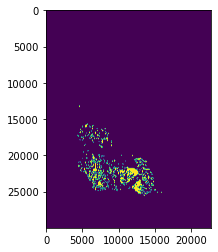

In [108]:
plt.imshow(mask_dict['region'])

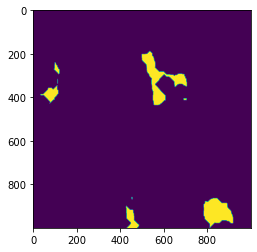

In [111]:
r1, r2, c1, c2 = 20000, 21000, 5000, 6000
plt.imshow(mask_dict['ductal'][r1:r2, c1:c2])

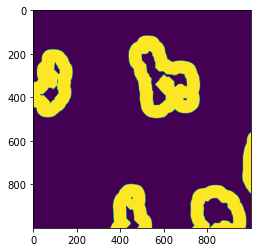

In [109]:
plt.imshow(mask_dict['myoepi'][r1:r2, c1:c2])

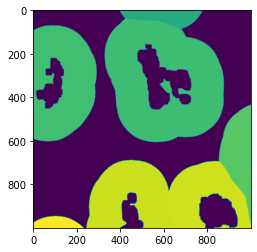

In [110]:
plt.imshow(labeled_dict['boundary'][r1:r2, c1:c2])

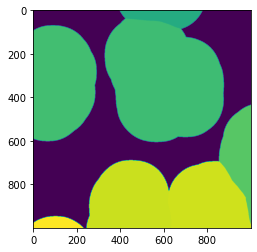

In [113]:
plt.imshow(labeled_dict['expanded'][r1:r2, c1:c2])

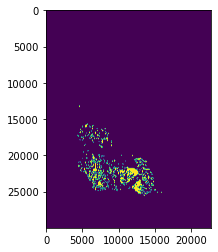

In [95]:
plt.imshow(labeled_dict['boundary'][r1:r2, c1:c2])

In [96]:
shrunk = fast_shrink_labels(labeled, 20)

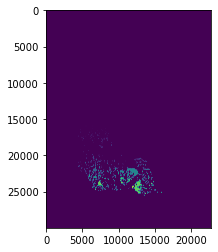

In [97]:
plt.imshow(shrunk)

In [58]:
def get_morphology_masks(labeled_img, myoepi_dist=40, boundary_dist=150):
    #expand by ~1 micron to avoid errors
    labeled_img = expand_labels(labeled_img, distance=2)
    mask = labeled_img > 0

    # myoepithelial
    outer_labeled = expand_labels(labeled_img, distance=myoepi_dist)
    myoepi_labeled = np.zeros_like(labeled_img)
    outer_mask = outer_labeled>0
    myoepi_mask = outer_mask ^ mask
    myoepi_labeled[myoepi_mask] = outer_labeled[myoepi_mask]

    # boundary
    outer_labeled = expand_labels(labeled_img, distance=boundary_dist)
    boundary_labeled = np.zeros_like(labeled_img)
    outer_mask = outer_labeled>0
    boundary_mask = outer_mask ^ mask
    boundary_labeled[boundary_mask] = outer_labeled[boundary_mask]

    labeled_dict = {
        'region': labeled_img,
        'myoepi': myoepi_labeled,
        'boundary': boundary_labeled,
        'expanded': outer_labeled,
    }
    mask_dict = {
        'region': mask,
        'myoepi': myoepi_mask,
        'boundary': boundary_mask,
        'expanded': outer_mask
    }

    return labeled_dict, mask_dict

In [59]:
labeled_dict, mask_dict = get_morphology_masks(labeled)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_258482/3825775212.py", line 1, in <module>
    labeled_dict, mask_dict = get_morphology_masks(labeled)
  File "/tmp/ipykernel_258482/2355365832.py", line 14, in get_morphology_masks
    outer_labeled = expand_labels(labeled_img, distance=boundary_dist)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/skimage/segmentation/_expand_labels.py", line 93, in expand_labels
    label_image == 0, return_indices=True
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/scipy/ndimage/morphology.py", line 2283, in distance_transform_edt
    if sampling is not None:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Tracebac

TypeError: object of type 'NoneType' has no len()

In [29]:
def generate_thresh_df(d):
    channel_df = pd.DataFrame({k:[v] for k, v in d.items()}).transpose()
    channel_df.index.name = 'channel'
    channel_df.columns = ['threshold']
    return channel_df

In [30]:
samples

['HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT206B1_H1',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_right_05122023',
 'HT271B1_S1H3A5_02172023',
 'HT297B1_H1_08042022',
 'HT305B1_S1H1',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_right_05122023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT339B1_H1A1',
 'HT339B1_H2A1',
 'HT339B1_H4A4',
 'HT365B1_S1H1_02132023',
 'HT397B1_H2A2',
 'HT397B1_H3A1',
 'HT397B1_S1H1A3U22_04122023',
 'HT397B1_S1H1A3U31_04062023',
 'HT397B1_U12_03172023',
 'HT397B1_U2_03162023',
 'HT480B1_S1H2_R001',
 'HT480B1_S1H2_R002',
 'HT565B1-H2_04262023']

In [31]:
sample_to_channel_thresh_pixel = {}
for sample, d in thresholds.items():
    sample_to_channel_thresh_pixel[sample] = generate_thresh_df(d)
sample_to_channel_thresh_pixel

{'HT365B1_S1H1_02132023':                  threshold
 channel                   
 CD8                   10.0
 Pan-Cytokeratin       50.0
 Podoplanin            10.0
 CK14                  20.0
 FOXP3                  7.0
 CD20                  10.0
 SMA                   10.0
 CD68                  45.0
 CD3e                  19.0
 CD45                  75.0,
 'HT271B1_S1H3A5_02172023':                  threshold
 channel                   
 CD8                   10.0
 Pan-Cytokeratin       15.0
 Podoplanin           254.0
 CD68                 254.0
 CD20                  15.0
 SMA                   15.0
 CD3e                  40.0
 CD45                  40.0
 CD31                  10.0,
 'HT397B1_U2_03162023':                  threshold
 channel                   
 CD8                   10.0
 Pan-Cytokeratin       46.0
 Podoplanin            10.0
 CD68                 254.0
 FOXP3                  8.0
 CD20                  10.0
 SMA                   10.0
 Ki67                  10.0

In [32]:
sample_to_channel_thresh_grid = sample_to_channel_thresh_pixel.copy()

In [33]:
# sample_to_channel_thresh_pixel = {
#     'HT206B1-H1': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT206B1_H1_06252022': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT323B1-H1A1': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT323B1-H1A4': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT323B1-H3': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT397B1-H2A2': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 300, 'SMA': 300, 'Podoplanin': 2000, 'MGP': 1000, 'Ki67': 5000}),
#     'HT397B1-H3A1': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 300, 'SMA': 300, 'Podoplanin': 2000, 'MGP': 1000, 'Ki67': 5000}),
# }

In [34]:
# sample_to_channel_thresh_grid = {
#     'HT206B1-H1': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT206B1_H1_06252022': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT323B1-H1A1': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT323B1-H1A4': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT323B1-H3': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 4000, 'SMA': 750, 'Podoplanin': 2000, 'MGP': 6000, 'Ki67': 5000}),
#     'HT397B1-H2A2': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 300, 'SMA': 300, 'Podoplanin': 2000, 'MGP': 1000, 'Ki67': 5000}),
#     'HT397B1-H3A1': generate_thresh_df({'E-cadherin': 4000, 'Pan-CK': 300, 'SMA': 300, 'Podoplanin': 2000, 'MGP': 1000, 'Ki67': 5000}),
# }
# # sample_to_channel_thresh_grid = {
# #     'HT206B1-H1': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# #     'HT206B1_H1_06252022': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# #     'HT323B1-H1A1': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# #     'HT323B1-H1A4': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# #     'HT323B1-H3': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# #     'HT397B1-H2A2': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# #     'HT397B1-H3A1': generate_thresh_df({'SMA': 1500, 'Podoplanin': 5000}),
# # }

In [35]:
# !rm -rf /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/htan_v1

In [36]:
run_dir = f'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis_v2/htan_v1'
for s in sample_to_feats:
    Path(os.path.join(run_dir, f'{s}')).mkdir(parents=True, exist_ok=True)

In [37]:
commands = []
for s in sample_to_feats:
    directory = os.path.join(run_dir, s, 'inputs')
    Path(directory).mkdir(parents=True, exist_ok=True)
    shutil.copy(sample_to_feats[s], os.path.join(directory, 'spatial_features.txt'))
    shutil.copy(sample_to_mask[s], os.path.join(directory, 'ductal_mask.tif'))
#     shutil.copy(sample_to_ome[s], os.path.join(directory, f'{s}.ome.tiff'))
    sample_to_channel_thresh_grid[s].to_csv(os.path.join(directory, 'channel_thresholds_grid.txt'), sep='\t')
    sample_to_channel_thresh_pixel[s].to_csv(os.path.join(directory, 'channel_thresholds_pixel.txt'), sep='\t')
    
    pieces = [
        'mip', 'generate-region-features',
        '--spatial-features', os.path.join(directory, 'spatial_features.txt'),
        '--ome-tiff', sample_to_ome[s],
        '--regions-mask', os.path.join(directory, 'ductal_mask.tif'),
        '--channel-thresholds-grid', os.path.join(directory, 'channel_thresholds_grid.txt'),
        '--channel-thresholds-pixel', os.path.join(directory, 'channel_thresholds_pixel.txt'),
        '--output-dir', os.path.join(run_dir, s, 'outputs'),
    ]
    cmd = ' '.join(pieces)
    commands.append(cmd)
commands[0]

'mip generate-region-features --spatial-features /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis_v2/htan_v1/HT110B1_S1H4/inputs/spatial_features.txt --ome-tiff /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff --regions-mask /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis_v2/htan_v1/HT110B1_S1H4/inputs/ductal_mask.tif --channel-thresholds-grid /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis_v2/htan_v1/HT110B1_S1H4/inputs/channel_thresholds_grid.txt --channel-thresholds-pixel /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis_v2/htan_v1/HT110B1_S1H4/inputs/channel_thresholds_pixel.txt --output-dir /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis_v2/htan_v1/HT110B1_S1H4/outputs'

In [38]:
f = open(os.path.join(run_dir, 'run.sh'), 'w')
f.write('\n'.join(commands))
f.close()

#### Angelo htan

In [248]:
ome_fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/',
                         regex='ome.tiff$'))
ome_fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2203_pt1072_31606.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2204_pt1071_31605.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2206_pt1116_31620.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2302_pt1046_20671.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2303_pt1047_20672.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2304_pt1089_20677.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/ome_tiffs/Point2305_pt2000_20689_Normal.ome.tiff',
 '/diskmnt/Projects/Users/estorrs/multipl

In [249]:
mask_fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/',
                         regex='tif$'))
mask_fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2203_pt1072_31606.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2204_pt1071_31605.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2206_pt1116_31620.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2302_pt1046_20671.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2303_pt1047_20672.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2304_pt1089_20677.tif',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point2305_pt2000_20689_Normal.tif',
 '/diskmnt/Projects/

In [250]:
feats_fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/',
                         regex='txt$'))
feats_fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2203.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2204.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2206.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2302.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2303.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2304.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2305.txt',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/spatial_features/Point2306.txt',


In [251]:
len(mask_fps), len(feats_fps), len(ome_fps)

(81, 79, 81)

In [252]:
point_to_mask = {}
for fp in mask_fps:
    pt = fp.split('/')[-1].split('_')[0].replace('Point', '')
    point_to_mask[pt] = fp
    
point_to_feats = {}
for fp in feats_fps:
    pt = fp.split('/')[-1].split('.')[0].replace('Point', '')
    point_to_feats[pt] = fp
    
point_to_ome = {}
for fp in ome_fps:
    pt = fp.split('/')[-1].split('_')[0].replace('Point', '')
    point_to_ome[pt] = fp

In [253]:
a = set(point_to_feats.keys())
b = set(point_to_mask.keys())
c = set(point_to_ome.keys())

len(a.intersection(b).intersection(c))

79

the two missing are tonsil

In [254]:
b - a

{'3201', '5311'}

In [255]:
[fp for fp in mask_fps if '5311' in fp]

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/preprocessing/angelo/region_mask_final/Point5311_31640_Tonsil.tif']

In [256]:
pt = next(iter(point_to_mask.keys()))
pt

'2203'

In [257]:
pt = '2204'

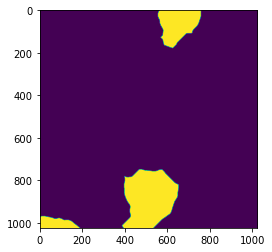

In [258]:
plt.imshow(tifffile.imread(point_to_mask[pt]))

In [259]:
df = pd.read_csv(point_to_feats[pt], sep='\t', index_col=0)
df

,x,y,cell_type
label,,,
5,931,1005,OTHER
6,560,143,TUMOR_ECADCK
9,564,170,TUMOR_LUMINAL
10,1015,889,MACS
11,496,891,TUMOR_LUMINAL
...,...,...,...
1423,196,461,CD8T
1431,67,809,MYOFIBRO
1435,212,1013,OTHER


<AxesSubplot:xlabel='x', ylabel='y'>

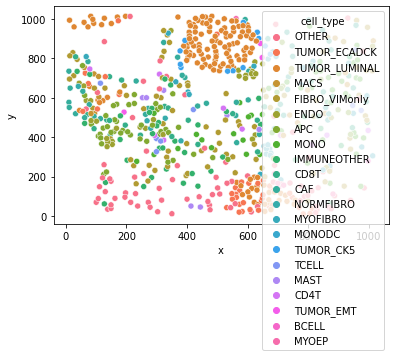

In [260]:
sns.scatterplot(data=df, x='x', y='y', hue='cell_type')

In [261]:
channel_dict = {
    'SMA': [.5],
    'PanKRT': [.5],
    'ECAD': [.5],
    'CK5': [.5],
    'CK7': [.5]
}
channel_df_grid = pd.DataFrame(channel_dict).transpose()
channel_df_grid.index.name = 'channel'
channel_df_grid.columns = ['threshold']
channel_df_grid

,threshold
channel,
SMA,0.5
PanKRT,0.5
ECAD,0.5
CK5,0.5
CK7,0.5


In [262]:
channel_dict = {
    'SMA': [.5],
    'PanKRT': [.5],
    'ECAD': [.5],
    'CK5': [.5],
    'CK7': [.5]
}
channel_df_pixel = pd.DataFrame(channel_dict).transpose()
channel_df_pixel.index.name = 'channel'
channel_df_pixel.columns = ['threshold']
channel_df_pixel

,threshold
channel,
SMA,0.5
PanKRT,0.5
ECAD,0.5
CK5,0.5
CK7,0.5


In [263]:
run_dir = f'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5'
for pt in point_to_feats:
    Path(os.path.join(run_dir, f'Point{pt}')).mkdir(parents=True, exist_ok=True)

In [264]:
commands = []
for pt in point_to_feats:
    directory = os.path.join(run_dir, f'Point{pt}', 'inputs')
    Path(directory).mkdir(parents=True, exist_ok=True)
    shutil.copy(point_to_feats[pt], os.path.join(directory, 'spatial_features.txt'))
    shutil.copy(point_to_mask[pt], os.path.join(directory, 'ductal_mask.tif'))
    shutil.copy(point_to_ome[pt], os.path.join(directory, f'{pt}.ome.tiff'))
    channel_df_grid.to_csv(os.path.join(directory, 'channel_thresholds_grid.txt'), sep='\t')
    channel_df_pixel.to_csv(os.path.join(directory, 'channel_thresholds_pixel.txt'), sep='\t')
    
    pieces = [
        'mip', 'generate-region-features',
        '--spatial-features', os.path.join(directory, 'spatial_features.txt'),
        '--ome-tiff', os.path.join(directory, f'{pt}.ome.tiff'),
        '--regions-mask', os.path.join(directory, 'ductal_mask.tif'),
        '--channel-thresholds-grid', os.path.join(directory, 'channel_thresholds_grid.txt'),
        '--channel-thresholds-pixel', os.path.join(directory, 'channel_thresholds_pixel.txt'),
        '--output-dir', os.path.join(run_dir, f'Point{pt}', 'outputs'),
    ]
    cmd = ' '.join(pieces)
    commands.append(cmd)
commands[0]

'mip generate-region-features --spatial-features /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/spatial_features.txt --ome-tiff /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/2203.ome.tiff --regions-mask /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/ductal_mask.tif --channel-thresholds-grid /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/channel_thresholds_grid.txt --channel-thresholds-pixel /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/channel_thresholds_pixel.txt --output-dir /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/outputs'

In [265]:
f = open(os.path.join(run_dir, 'run.sh'), 'w')
f.write('\n'.join(commands))
f.close()

In [266]:
commands[0]

'mip generate-region-features --spatial-features /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/spatial_features.txt --ome-tiff /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/2203.ome.tiff --regions-mask /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/ductal_mask.tif --channel-thresholds-grid /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/channel_thresholds_grid.txt --channel-thresholds-pixel /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/inputs/channel_thresholds_pixel.txt --output-dir /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/dcis_region_analysis/angelo_v5/Point2203/outputs'

#### in house

In [23]:
sample_id = 'HT206B1_H1_06252022'
run_dir = f'/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/region_metrics/{sample_id}'
Path(run_dir).mkdir(parents=True, exist_ok=True)

In [3]:
a = sc.read_h5ad(f'../../multiplex_data/analysis/brca_dcis_v1/metaclustered/{sample_id}.h5ad')
a.obs

,area,perimeter,bbox_row_min,bbox_col_min,bbox_row_max,bbox_col_max,centroid_row,centroid_col,eccentricity,DAPI intensity max,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,metacluster
HT206B1_H1_06252022_1,380,74.041631,0,4821,19,4846,7.505263,4832.971053,0.683004,18790.0,...,0.000000,0.618568,0.019604,0.000000,0.010007,0.000000,0.000000,0.000000,0.303525,Endothelial
HT206B1_H1_06252022_2,310,70.627417,0,4845,16,4868,6.541935,4856.164516,0.722101,61606.0,...,0.000000,0.743646,0.023065,0.000000,0.011769,0.000000,0.000000,0.010209,0.164716,Endothelial
HT206B1_H1_06252022_3,278,80.870058,0,4867,14,4897,4.733813,4879.276978,0.931353,24283.0,...,0.000000,0.821627,0.017061,0.000000,0.000000,0.000000,0.000000,0.000000,0.110602,Endothelial
HT206B1_H1_06252022_4,833,111.941125,0,5634,25,5674,10.346939,5653.015606,0.774127,35152.0,...,0.032994,0.029690,0.078039,0.031300,0.039833,0.031215,0.032178,0.034552,0.660189,Tumor
HT206B1_H1_06252022_5,592,92.769553,0,5721,24,5753,9.847973,5735.261824,0.674520,51562.0,...,0.000000,0.000000,0.019633,0.556573,0.010007,0.000000,0.000000,0.000000,0.365894,Macrophage M1 enriched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT206B1_H1_06252022_136402,48,32.349242,20149,10223,20157,10236,20152.750000,10230.020833,0.877933,6102.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.969482,Tumor
HT206B1_H1_06252022_136403,222,73.627417,20150,10913,20160,10942,20155.333333,10927.900901,0.945689,18912.0,...,0.000000,0.000000,0.010322,0.000000,0.000000,0.000000,0.000000,0.000000,0.955039,Tumor
HT206B1_H1_06252022_136404,108,59.798990,20152,10212,20160,10236,20156.500000,10223.629630,0.952507,15680.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965823,Tumor
HT206B1_H1_06252022_136405,56,33.556349,20154,10458,20160,10473,20157.357143,10465.946429,0.931476,14481.0,...,0.000000,0.000000,0.011221,0.000000,0.000000,0.000000,0.000000,0.000000,0.951174,Tumor


In [6]:
feats = a.obs[['centroid_col', 'centroid_row', 'harmonized_cell_type', 'metacluster']]
feats.columns = ['X', 'Y', 'cell_type', 'metacluster']
feats.index.name = 'cell_id'
feats

,X,Y,cell_type,metacluster
cell_id,,,,
HT206B1_H1_06252022_1,4832.971053,7.505263,Fibroblast,Endothelial
HT206B1_H1_06252022_2,4856.164516,6.541935,Endothelial,Endothelial
HT206B1_H1_06252022_3,4879.276978,4.733813,Endothelial,Endothelial
HT206B1_H1_06252022_4,5653.015606,10.346939,Tumor,Tumor
HT206B1_H1_06252022_5,5735.261824,9.847973,Tumor,Macrophage M1 enriched
...,...,...,...,...
HT206B1_H1_06252022_136402,10230.020833,20152.750000,Tumor,Tumor
HT206B1_H1_06252022_136403,10927.900901,20155.333333,Tumor,Tumor
HT206B1_H1_06252022_136404,10223.629630,20156.500000,Tumor,Tumor


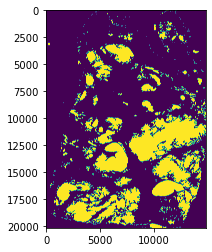

In [24]:
tumor_regions_tif = f'/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/{sample_id}/level_3/annotations/tumor_mask_10_alpha.tif'
tumor_regions = tifffile.imread(tumor_regions_tif)
plt.imshow(tumor_regions)

In [15]:
channel_dict = {
    'SMA': [1500],
    'Podoplanin': [5000]
}
channel_df = pd.DataFrame(channel_dict).transpose()
channel_df.index.name = 'channel'
channel_df.columns = ['threshold']
channel_df

,threshold
channel,
SMA,1500
Podoplanin,5000


In [25]:
input_dir = os.path.join(run_dir, 'inputs')
Path(input_dir).mkdir(parents=True, exist_ok=True)

In [26]:
feats_fp = os.path.join(input_dir, 'spatial_features.txt')
feats.to_csv(feats_fp, sep='\t')

In [27]:
channel_fp = os.path.join(input_dir, 'channel_thresholds.txt')
channel_df.to_csv(channel_fp, sep='\t')

In [31]:
ome_tiff_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_2/HT206B1_H1_06252022.ome.tiff'

In [29]:
out_dir = os.path.join(run_dir, 'outputs')
Path(input_dir).mkdir(parents=True, exist_ok=True)

In [32]:
command = f'mip generate-region-features --spatial-features {feats_fp} \
--ome-tiff {ome_tiff_fp} --regions-mask {tumor_regions_tif} --channel-thresholds {channel_fp} \
--output-dir {out_dir} --max-region-size 50000'

command

'mip generate-region-features --spatial-features /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/region_metrics/HT206B1_H1_06252022/inputs/spatial_features.txt --ome-tiff /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_2/HT206B1_H1_06252022.ome.tiff --regions-mask /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_3/annotations/tumor_mask_10_alpha.tif --channel-thresholds /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/region_metrics/HT206B1_H1_06252022/inputs/channel_thresholds.txt --output-dir /diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/region_metrics/HT206B1_H1_06252022/outputs --max-region-size 50000'